# **Import Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")
import spotipy.util as util

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
data = pd.read_csv("../Desktop/data/data.csv")
genre_data = pd.read_csv('../Desktop/data/data_by_genres.csv')
year_data = pd.read_csv('../Desktop/data/data_by_year.csv')

In [ ]:
print(data.info())
data.head()

In [ ]:
print(genre_data.info())
genre_data.head()

In [ ]:
print(year_data.info())
year_data.head()

In [ ]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

<AxesSubplot:xlabel='decade', ylabel='count'>

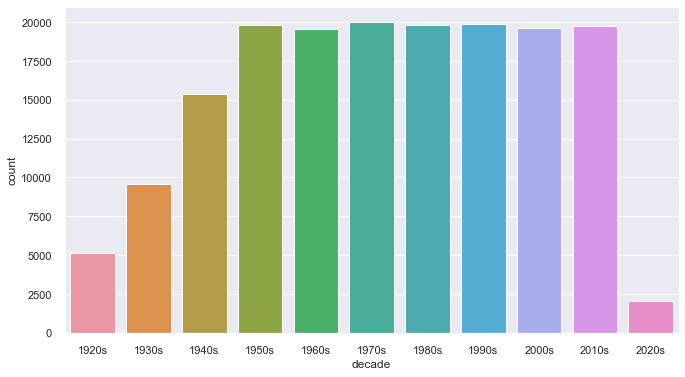

In [81]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(data['decade'])

In [82]:
import plotly_express as px 

sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

In [83]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

In [73]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [74]:
# Visualizing the Clusters with t-SNE

from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.024s...
[t-SNE] Computed neighbors for 2973 samples in 0.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.116173
[t-SNE] KL divergence after 1000 iterations: 1.387725


# **Clustering Songs with K-Means**

In [75]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

# Visualizing the Clusters with PCA

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In [110]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dictionary = pd.read_csv('..\Desktop\data\data.csv', index_col=0, squeeze=True).to_dict()

dataset=[dictionary]
number_cols = [dictionary]
user={"danceability": 0.7, "energy": 0.6, "loudness": 1.5, "acousticness": 0.2, "liveness": 0.1}

class SoftSet:
    @staticmethod
    def soft(dataset, user, number_cols):
        values = []
        names = []
        for row in dataset:
            tmp = 0
            names.append(dataset)
            for key in user:
                tmp += row[key]*user[key]
            values.append(tmp)
            nmax=max(values)

            max_index = values.index(max(values))
        return number_cols[max_index]

SoftSet.soft(dataset,user, number_cols)

TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from collections import defaultdict

sp = spotipy.Spotify(auth_manager = SpotifyOAuth(client_id="b2012e3d9486471681d6f08074cfc7aa",
                                                      client_secret="ac9214c652cc45f6b30d58dbf810b72a",
                                                      redirect_uri = "http://localhost:8888/callback/"
                                                      ))
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
recommend_songs([{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}],data)

In [ ]:
recommend_songs.head()

In [ ]:
def generate_recommended_playlist(playlist_name, playlist_dic, spotify_data):
    
    playlist = pd.DataFrame()

    for i, j in enumerate(sp.playlist(playlist_dic[playlist_name])['tracks']['items']):
        playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
        playlist.loc[i, 'track_name'] = j['track']['name']
        playlist.loc[i, 'track_id'] = j['track']['id']
        playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
        playlist.loc[i, 'date_added'] = j['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['track_id'].isin(spotify_data['track_id'].values)].sort_values('date_added',ascending = False)

    return playlist
playlist_df = generate_playlist_df('MixedMood', playlist_dic, spotify_data) 

playlist_df.head()


In [ ]:
import matplotlib.pyplot as plt

def visualize_cover_art(data):
    temp = data['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))) , facecolor='#8cfc03')
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s='' 
        plt.xlabel(s.join(data['track_name'].values[i].split(' ')[:4]), fontsize = 10, fontweight='bold')
        plt.tight_layout(h_pad=0.8, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()


playlist_cover_art = {}

for i in sp.current_user_playlists()['items']:
    playlist_cover_art[i['uri'].split(':')[2]] = i['images'][0]['url']

visualize_cover_art(recommend_songs)